In [1]:
import sys
import os
import cv2
import itertools
import pickle
import struct
import numpy as np
import scipy.io
from PIL import Image, ImageFilter
from random import shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def pickle_operating(fname, item):
    # save or load the pickle file.
    file_name = '%s.pickle' % fname
    print(file_name)
    if not item:
        with open(file_name, 'rb') as fs:
            item = pickle.load(fs)
            return item
    else:
        with open(file_name, 'wb') as fs:
            pickle.dump(item, fs, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
#loading the binary files for MNIST datasets
def load_MNIST(dataset="training", path='../MNIST/'):
    if dataset is "training":
        f_img = os.path.join(path, 'train-images.idx3-ubyte')
        f_labels = os.path.join(path, 'train-labels.idx1-ubyte')
    else:
        f_img = os.path.join(path, 't10k-images.idx3-ubyte')
        f_labels = os.path.join(path, 't10k-labels.idx1-ubyte')

    with open(f_labels, 'rb') as flabels:
        magic, num = struct.unpack(">II", flabels.read(8))
        labels = np.fromfile(flabels, dtype=np.int8)

    with open(f_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        imgs = np.fromfile(fimg, dtype=np.uint8).reshape(len(labels), rows, cols)
    return imgs, labels

In [3]:
#deskewing the image of MNIST for 
#better improvement of features quality
def deskew(img):
    SZ = 40
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2: return img.copy()
    skew = m['mu11']/m['mu02'] 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    return cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

In [4]:
imgs_train, labels_train = load_MNIST('training')
imgs_test, labels_test = load_MNIST('testing')

In [5]:
#performing necessary preprocessing steps for MNIST dataset
def preprocess_MNIST_imgs(data):
    imgs = []
    for img in data:
        img = deskew(img)
        image = img.flatten()
        imgs.append(image)
    return imgs

In [6]:
#principal component analysis for feature selection
def pca(X_train, n_feature):
    pca = PCA(n_components=n_feature)
    pca.fit(X_train)
    return pca

In [7]:
MNIST_data = {}
data_train = preprocess_MNIST_imgs(imgs_train)
data_test = preprocess_MNIST_imgs(imgs_test)
MNIST_data['train'], MNIST_data['test'] = [data_train, labels_train], [data_test, labels_test]
pickle_operating('MNIST_data_1', MNIST_data)

MNIST_data_1.pickle


Accumulative number of features: 1600


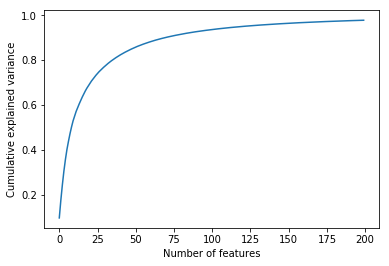

In [8]:
mnist_pca = pca(MNIST_data['train'][0], 200)
print("Accumulative number of features: %s" % len(MNIST_data['train'][0][0]))

plt.plot(np.cumsum(mnist_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.show()

In [9]:
mnist_pca = pca(MNIST_data['train'][0], 16)

MNIST_data['train'][0] = mnist_pca.transform(MNIST_data['train'][0])
MNIST_data['test'][0] = mnist_pca.transform(MNIST_data['test'][0])
MNIST_data['train'] = [(MNIST_data['train'][0][i], MNIST_data['train'][1][i]) for i in range(len(MNIST_data['train'][0]))]
MNIST_data['test'] = [(MNIST_data['test'][0][i], MNIST_data['test'][1][i]) for i in range(len(MNIST_data['test'][0]))]
pickle_operating('MNIST_data_2', MNIST_data)

MNIST_data_2.pickle


In [10]:
#structures folders for Caltech
structures = [x for x in os.walk('../Caltech10/')]

In [11]:
#performing necessary preprocessing steps for Caltech images
def preprocess_Caltech_imgs(folders):
    dataset = {'categories': {}, 'data': {}}
    data = []
    label = 0
    size = (128, 128)
    for f in folders:
        dataset['categories'][f[0]] = label
        dataset['data'][label] = []
        for i in f[2]:
            #image = Image.open("%s/%s"%(f[0], i)).resize(size)
            #image = image.convert("L").filter(ImageFilter.GaussianBlur(radius = 2))
            #im_data = list(image.getdata())
            img = cv2.imread("%s/%s"%(f[0], i))
            resized_img = cv2.resize(img, size) #resizing the img
            im_data = resized_img.flatten() #flatten the image
            dataset['data'][label].append((im_data, label))
        label += 1
    return dataset

In [12]:
#splitting 50% for testing and training data for Caltech
def train_test_splitting(size, data):
    train_data, test_data = [], []
    for i in data.keys():
        x = range(len(data[i]))
        shuffle(x)
        train_size = int(size*len(data[i]))
        train_indexes, test_indexes = x[:train_size], x[train_size:]
        train_data.extend(np.array(data[i])[train_indexes]) 
        test_data.extend(np.array(data[i])[test_indexes])
    del train_data[0]
    del test_data[0]
    return train_data, test_data

In [13]:
dataset_temp = preprocess_Caltech_imgs(structures)
caltech_data = {}
caltech_data['train'], caltech_data['test'] = [], []
caltech_data['train'], caltech_data['test'] = train_test_splitting(0.5, dataset_temp['data'])
pickle_operating('Caltech_data_1', caltech_data)

Caltech_data_1.pickle


Accumulative number of features: 49152


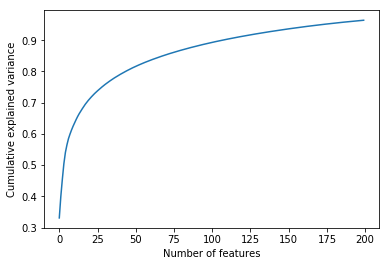

In [14]:
caltech_train = [x[0] for x in caltech_data['train']]
caltech_test = [x[0] for x in caltech_data['test']]
print("Accumulative number of features: %s" % len(caltech_train[0]))
caltech_pca = pca(caltech_train, 200)

plt.plot(np.cumsum(caltech_pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Cumulative explained variance')
plt.show()

In [15]:
caltech_pca = pca(caltech_train, 50)
caltech_train_pca = caltech_pca.transform(caltech_train)
caltech_test_pca = caltech_pca.transform(caltech_test)
caltech_data['train'] = [(caltech_train_pca[i], caltech_data['train'][i][1]) for i in range(len(caltech_train_pca))]
caltech_data['test'] = [(caltech_test_pca[i], caltech_data['test'][i][1]) for i in range(len(caltech_test_pca))]
pickle_operating('Caltech_data_2', caltech_data)

Caltech_data_2.pickle
